In [384]:
import numpy as np
import pandas as pd
import catboost as cb
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from catboost.utils import create_cd

import config

%load_ext autoreload
%autoreload 2

DATA_PATH = config.get_data_path()

TRAIN_FEATURES = DATA_PATH / 'train_features.csv'
TEST_FEATURES = DATA_PATH / 'test_features.csv'

train_df = pd.read_csv(TRAIN_FEATURES, index_col=0, parse_dates=['event_dttm'])
test_df = pd.read_csv(TEST_FEATURES, index_col=0, parse_dates=['event_dttm'])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [385]:
train_df = train_df.fillna(-999)
test_df = test_df.fillna(-999)

In [386]:
train_df = train_df.sort_values('event_dttm')

In [389]:
def postprocess_probs(probs, thresh):
    weights = np.array([[-10, -0.1, 0.1, 0.5]])
    probs = np.sum(probs * weights, axis=1)
    binarized = probs > thresh
    binarized = binarized * 2 - 1
    return binarized

def score(probs, y_true):
    answers = postprocess_probs(probs)
    id2w = config.id2w()
    true_weights = np.array(list(map(id2w.get, y_true)))
    our_score = (true_weights * answers).sum()
    best_score = np.abs(true_weights).sum()
    
    return our_score / best_score

def score_attrs(probs, y_true):
    answers = postprocess_probs(probs)
    id2w = config.id2w()
    true_weights = np.array(list(map(id2w.get, y_true)))
    our_score = np.cumsum(true_weights * answers)
    best_score = np.cumsum(np.abs(true_weights))
    
    return our_score, best_score

In [390]:
# sums_if_cols = list(train_df.columns[train_df.columns.str.startswith('sum_')])

In [391]:
to_drop = ['clusters']
# to_drop = []

In [304]:
X_train_full = train_df.drop(
    ['event', 'event_dttm'] + to_drop,
    axis=1
)
y_train_full = train_df['event']

X_test = test_df.drop(
    ['answer_id', 'event_dttm'] + to_drop,
    axis=1
)
answer_id = test_df['answer_id']

In [305]:
# X_train_full = X_train_full.sort_values('event_dttm')

In [306]:
X_train_full['event_dttm'] = range(X_train_full.shape[0])

# X_train_full = X_train_full.drop(['event_dttm'], axis=1)

In [307]:
X_test['event_dttm'] = range(X_train_full.shape[0], X_train_full.shape[0] + X_test.shape[0])

In [308]:
# X_train_full = train_df[features]
# y_train_full = train_df['event']

# X_test = test_df[features]
# answer_id = test_df['answer_id']

In [309]:
# cat_features = [
#     'customer_id', 'story_id', 'product_4', 'product_5', 'product_0', 'hour'
# ]

In [310]:
cat_features = ['customer_id', 'story_id', 'is_weeked',
                'product_0', 'product_1', 'product_2', 'product_3', 'product_4', 'product_5', 'product_6',
                'marital_status_cd', 'job_position_cd', 'prod_not_nan',
]
# cat_features = ['customer_id', 'story_id']

In [312]:
# cd = create_cd(timestamp=83)

In [313]:
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, shuffle=False)

In [339]:
params = {
    'iterations': 4000, 
#     'task_type': 'GPU',
#     'devices': '1-7',
    'verbose': 100,
#     'early_stopping_rounds': 200,
    'loss_function': 'MultiClass',    
#     'has_time': True
}

In [340]:
model = cb.CatBoostClassifier(**params)

In [341]:
model.fit(X_train_full, y_train_full, 
          cat_features=cat_features, 
#           eval_set=(X_val, y_val),
          plot=True,
#           column_description=cd,
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1.3574715	total: 597ms	remaining: 39m 47s
100:	learn: 0.8070628	total: 51.8s	remaining: 33m 21s
200:	learn: 0.7742754	total: 1m 54s	remaining: 36m 3s
300:	learn: 0.7633734	total: 2m 59s	remaining: 36m 41s
400:	learn: 0.7576177	total: 4m 4s	remaining: 36m 36s
500:	learn: 0.7530551	total: 5m 11s	remaining: 36m 14s
600:	learn: 0.7493228	total: 6m 16s	remaining: 35m 30s
700:	learn: 0.7466024	total: 7m 21s	remaining: 34m 39s
800:	learn: 0.7443230	total: 8m 28s	remaining: 33m 49s
900:	learn: 0.7425677	total: 9m 33s	remaining: 32m 51s
1000:	learn: 0.7408944	total: 10m 39s	remaining: 31m 54s
1100:	learn: 0.7396251	total: 11m 43s	remaining: 30m 51s
1200:	learn: 0.7382586	total: 12m 49s	remaining: 29m 53s
1300:	learn: 0.7370162	total: 13m 55s	remaining: 28m 54s
1400:	learn: 0.7359485	total: 15m 2s	remaining: 27m 54s
1500:	learn: 0.7347922	total: 16m 8s	remaining: 26m 52s
1600:	learn: 0.7338267	total: 17m 14s	remaining: 25m 50s
1700:	learn: 0.7328661	total: 18m 20s	remaining: 24m 47s
18

In [316]:
model.fit(X_train_full, y_train_full, 
          cat_features=cat_features, 
#           eval_set=(X_val, y_val),
          plot=True,
#           column_description=cd,
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1.3579567	test: 1.3598302	best: 1.3598302 (0)	total: 585ms	remaining: 19m 30s
100:	learn: 0.8209969	test: 0.8334527	best: 0.8334527 (100)	total: 44.4s	remaining: 13m 55s
200:	learn: 0.7907939	test: 0.8072276	best: 0.8071337 (199)	total: 1m 41s	remaining: 15m 12s
300:	learn: 0.7804630	test: 0.8042266	best: 0.8042266 (300)	total: 2m 43s	remaining: 15m 23s
400:	learn: 0.7744830	test: 0.8030565	best: 0.8030565 (400)	total: 3m 44s	remaining: 14m 54s
500:	learn: 0.7697256	test: 0.8020098	best: 0.8020098 (500)	total: 4m 45s	remaining: 14m 13s
600:	learn: 0.7660893	test: 0.8015527	best: 0.8014089 (599)	total: 5m 47s	remaining: 13m 28s
700:	learn: 0.7630792	test: 0.8006322	best: 0.8006235 (699)	total: 6m 48s	remaining: 12m 36s
800:	learn: 0.7608326	test: 0.8003895	best: 0.8003139 (731)	total: 7m 49s	remaining: 11m 42s
900:	learn: 0.7587445	test: 0.7997926	best: 0.7997574 (888)	total: 8m 50s	remaining: 10m 47s
1000:	learn: 0.7566736	test: 0.7989548	best: 0.7987608 (974)	total: 9m 51s	r

In [317]:
def my_score(probs, y_true):
    answers = probs
    id2w = config.id2w()
    true_weights = np.array(list(map(id2w.get, y_true)))
    our_score = (true_weights * answers).sum()
    best_score = np.abs(true_weights).sum()
    
    return our_score / best_score

In [318]:
val_probs = model.predict_proba(X_val)

In [319]:
postprocess_probs(val_probs)

array([ 1, -1, -1, ...,  1, -1, -1])

In [320]:
weights = np.array([[-10, -0.1, 0.1, 0.5]])
weighted_ans = np.sum(val_probs * weights, axis=1)

In [321]:
np.sum(weighted_ans > 0)

43128

In [330]:
post = (weighted_ans > -0.007) * 2 - 1
post[np.abs(weighted_ans) < 0] = 0
print(np.sum(post > 0))

my_score(post, y_val)

46463


0.42418740790287607

In [325]:
np.sum(weighted_ans > 0)

43128

In [331]:
print(score(val_probs, y_val))

0.41848430136944953


In [207]:
cols = X_train.columns
imps = model.feature_importances_
col_imps = sorted(zip(imps, cols), reverse=True)

In [208]:
col_imps

[(36.42444239256027, 'customer_id'),
 (23.768011659182523, 'story_id'),
 (4.322945551176629, 'clusters'),
 (2.0429556702664553, 'text_len'),
 (1.763252471344035, 'mean_font_size'),
 (1.759552249218278, 'event_dttm'),
 (1.6888427765584337, 'age'),
 (1.4571961005107525, 'product_5'),
 (1.4255084229237267, 'positive'),
 (1.2541441581532158, 'text_amount'),
 (1.0632790627620856, 'negative'),
 (1.051481677428478, 'hour'),
 (0.9928019181494744, 'product_0'),
 (0.9907628399186824, 'num_messages'),
 (0.9695150444981402, 'product_4'),
 (0.945286118982457, 'num_guids'),
 (0.9067004851552465, 'num_urls'),
 (0.8988073115240048, 'num_pages'),
 (0.8497233567102829, 'product_3'),
 (0.846854800107462, 'neutral'),
 (0.7918311994039173, 'speech'),
 (0.7894035386015136, 'product_1'),
 (0.7418431027007462, 'product_6'),
 (0.7297308769357361, 'num_elements'),
 (0.651181086444595, 'prod_not_nan'),
 (0.6319373295852168, 'num_trans'),
 (0.6206487872318966, 'marital_status_cd'),
 (0.5782962501180534, 'gender_c

In [206]:
X_train.columns

Index(['customer_id', 'story_id', 'weekday', 'day', 'hour', 'minute',
       'is_weeked', 'product_0', 'product_1', 'product_2', 'product_3',
       'product_4', 'product_5', 'product_6', 'gender_cd', 'age',
       'marital_status_cd', 'children_cnt', 'job_position_cd', 'prod_not_nan',
       'prod_sum_opn', 'prod_sum_utl', 'prod_sum_cls', 'num_pages', 'num_urls',
       'num_elements', 'mean_font_size', 'text_amount', 'clusters', 'neutral',
       'negative', 'skip', 'speech', 'positive', 'num_messages', 'text_len',
       'num_guids', 'sum_amount', 'mean_amount', 'num_trans', 'std_amount',
       'std_amount_normalized', 'sum_amount_if_retail_shops',
       'sum_amount_if_retail_shops_percentage', 'sum_amount_if_other_shops',
       'sum_amount_if_other_shops_percentage',
       'sum_amount_if_professional_service',
       'sum_amount_if_professional_service_percentage',
       'sum_amount_if_transport', 'sum_amount_if_transport_percentage',
       'sum_amount_if_unknown', 'sum_amoun

In [350]:
new_probs = val_probs * np.array([[0.9, 1, 0.8, 1]])
new_probs = (new_probs / new_probs.sum(axis=1, keepdims=True))

0.30753205722858035


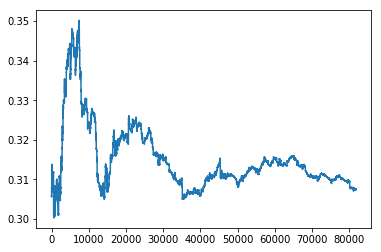

In [368]:
our_score, best_score = score_attrs(new_probs[80000:], y_val[80000:])
plt.plot((our_score / best_score)[10000:])
# plt.plot(our_score / 10000)
# plt.plot(best_score / 10000)
print(score(new_probs[80000:], y_val[80000:]))

In [377]:
print(score(val_probs, y_val[120000:]))

0.2912443335200937


0.303418554230918


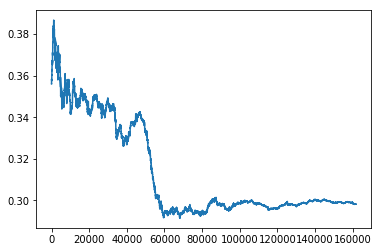

In [353]:
our_score, best_score = score_attrs(val_probs, y_val)
plt.plot((our_score / best_score)[10000:])
# plt.plot(our_score / 10000)
# plt.plot(best_score / 10000)
print(score(val_probs[80000:], y_val[80000:]))

In [156]:
Counter(y_train_full)

Counter({1: 167567, 2: 242312, 3: 56687, 0: 6575})

In [141]:
len(y_train) + 75000

376390

In [212]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='valid')
    return y_smooth

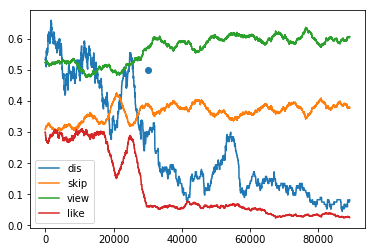

In [528]:
# plt.plot(smooth(y_val == 3, 3000))
plt.plot(smooth(y_train_full[380000:] == 0, 4000) * 30, label='dis')
plt.plot(smooth(y_train_full[380000:] == 1, 4000), label='skip')
plt.plot(smooth(y_train_full[380000:] == 2, 4000), label='view')
plt.plot(smooth(y_train_full[380000:] == 3, 4000) * 2, label='like')
plt.scatter(30000, 0.5)
# plt.scatter(450000, 0.5)


plt.legend()

In [510]:
473000 - 420000

53000

In [511]:
25000 / 473000

0.052854122621564484

In [533]:
sample_weights = np.ones(y_train_full.shape)

sample_weights[410000:] = 5

array([1., 1., 1., ..., 5., 5., 5.])

In [542]:
cluster_set = set(train_df['clusters'].unique())

In [549]:
from collections import Counter

In [567]:
default = Counter(train_df['event'])

len_df = len(train_df)
default[0] / len_df, default[1] / len_df, default[2] / len_df, default[3] / len_df

(0.013896491743476047,
 0.3541586968789431,
 0.5121348604327252,
 0.11980995094485576)

In [580]:
len_df

13419

In [581]:
cluster = 7
stats = Counter(train_df[train_df['clusters'] == cluster]['event'])

len_df = np.sum(train_df['clusters'] == cluster)

stats[0] / len_df, stats[1] / len_df, stats[2] / len_df, stats[3] / len_df

(0.0, 0.48960429242119385, 0.5103957075788061, 0.0)

In [573]:
train_df[train_df['clusters'] == 2]

,customer_id,story_id,event_dttm,event,weekday,day,hour,minute,is_weeked,product_0,...,sum_amount_if_contract_service_percentage,answer_id,this_story_after_counter,this_story_before_counter,stories_before_counter,stories_after_counter,nearest_story_seconds_before,nearest_story_seconds_after,stories_at_all,this_story_at_all
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
415190,843538,428,2018-04-03 05:13:38,1.0,1,3,5,13,0,-1.0,...,0.0,-999.0,0.0,0.0,2.0,7.0,22626.0,67655.0,9.0,0.0
415189,843538,419,2018-04-03 05:13:38,2.0,1,3,5,13,0,-1.0,...,0.0,-999.0,0.0,0.0,4.0,5.0,22626.0,67655.0,9.0,0.0
415194,843538,609,2018-04-03 05:13:38,1.0,1,3,5,13,0,-1.0,...,0.0,-999.0,0.0,0.0,6.0,3.0,22626.0,67655.0,9.0,0.0
231099,441292,323,2018-04-17 01:47:46,1.0,1,17,1,47,0,-1.0,...,0.0,-999.0,0.0,0.0,2.0,165.0,28013.0,27647.0,167.0,0.0
231138,441292,770,2018-04-24 09:28:33,1.0,1,24,9,28,0,-1.0,...,0.0,-999.0,0.0,0.0,8.0,159.0,58753.0,30695.0,167.0,0.0
74652,149332,778,2018-04-26 12:15:54,1.0,3,26,12,15,0,-1.0,...,0.0,-999.0,0.0,0.0,0.0,48.0,-999.0,73659.0,48.0,0.0
231143,441292,784,2018-04-27 17:30:30,1.0,4,27,17,30,0,-1.0,...,0.0,-999.0,0.0,0.0,12.0,155.0,1778.0,47553.0,167.0,0.0
127437,231444,516,2018-05-08 04:21:56,1.0,1,8,4,21,0,-1.0,...,0.0,-999.0,0.0,0.0,2.0,23.0,-999.0,12620.0,25.0,0.0
117787,214454,784,2018-05-08 09:04:52,1.0,1,8,9,4,0,-1.0,...,0.0,-999.0,0.0,0.0,4.0,56.0,68069.0,30326.0,60.0,0.0


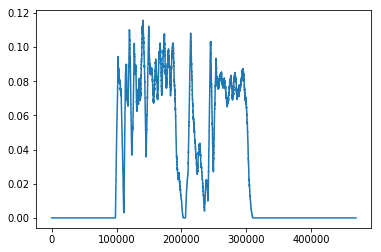

In [633]:
plt.plot(smooth(train_df['clusters'] == 7, 4000), label='cluster7')

In [615]:
np.sum(train_df['story_id'] == 322)

0

In [598]:
np.sum(train_df['story_id'] == 501)

0

In [619]:
np.sum(train_df['clusters'] == 0)

126796

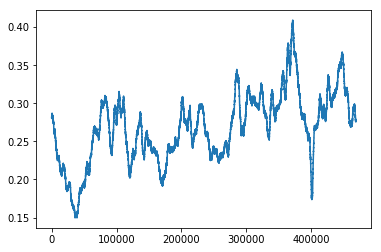

In [621]:
plt.plot(smooth(train_df['clusters'] == 0, 4000), label='cluster7')

Unnamed: 0
415192    False
415188    False
376367    False
415190    False
415189    False
415193    False
415194    False
415195    False
415191    False
376368    False
376372    False
231120    False
231108    False
231126    False
231099    False
231128    False
212313    False
231124    False
231117    False
231137    False
231138    False
231139    False
231118    False
231140    False
91560     False
74650     False
74652     False
340810    False
231143    False
231127    False
          ...  
457337    False
457414    False
457415    False
457327    False
457419    False
457344    False
457391    False
367338    False
367409    False
367439    False
367440    False
367441    False
308139    False
319261    False
319260    False
199540    False
199541    False
199545    False
199551    False
254112    False
254110    False
254109    False
254107    False
254108    False
15279     False
15278     False
172958    False
172956    False
463994    False
405956    False
Name: cluster

In [509]:
y_train_full.shape`

(473141,)

In [470]:
a = y_train_full[:40000]

In [476]:
np.sum(a == 0) / (np.sum(a == 1) + np.sum(a == 0))

0.04118743465017957

In [477]:
np.sum(a == 0) / np.sum(a == 1) 

0.04295671139348537

In [469]:
(np.sum(a == 2) + np.sum(a == 3)) / len(a)

0.6205754502173463

In [502]:
my_score(-np.ones(y_train_full[470000:].shape), y_train_full[470000:])

0.009097270818754374

In [498]:
y_train_full.shape

(473141,)

In [146]:
from collections import Counter

In [156]:
Counter(y_train_full)

Counter({1: 167567, 2: 242312, 3: 56687, 0: 6575})

In [171]:
sorted(np.array(list(Counter(y_train_full[:400000]).values())) / len(y_train_full[:400000]))

[0.015335, 0.1351775, 0.3504625, 0.499025]

In [147]:
Counter(y_train_full[400000:])

Counter({2: 42702, 3: 2616, 1: 27382, 0: 441})

In [170]:
sorted(np.array(list(Counter(y_train_full[400000:]).values())) / len(y_train_full[400000:]))

[0.006029449966503056,
 0.03576653313463037,
 0.37437278680904007,
 0.5838312300898265]

In [193]:
sorted(np.array(list(Counter(y_train).values())) / len(y_train))

[0.014300408109094529,
 0.13033279139984738,
 0.3558114071468861,
 0.499555393344172]

In [174]:
a = val_probs.argmax(axis=1)

In [192]:
val_probs.mean(axis=0)

array([0.0108211 , 0.31641583, 0.55940055, 0.11336252])

In [97]:
our_score

array([1.00000e-01, 2.00000e-01, 3.00000e-01, ..., 1.38904e+04,
       1.38903e+04, 1.38902e+04])

In [92]:
score(val_probs, y_val)

0.3480454035677105

In [21]:
X_train.iloc[:, -1]

Unnamed: 0
415192         0
415188         1
376367         2
415190         3
415189         4
415193         5
415194         6
415195         7
415191         8
376368         9
376372        10
231120        11
231108        12
231126        13
231099        14
231128        15
212313        16
231124        17
231117        18
231137        19
231138        20
231139        21
231118        22
231140        23
91560         24
74650         25
74652         26
340810        27
231143        28
231127        29
           ...  
290378    378482
290366    378483
290298    378484
254747    378485
254746    378486
254745    378487
254744    378488
254743    378489
254741    378490
254740    378491
254739    378492
254738    378493
254742    378494
293265    378495
293070    378496
293267    378497
293251    378498
409925    378499
409813    378500
409927    378501
409908    378502
409929    378503
409923    378504
409881    378505
409894    378506
409920    378507
409907    378508
409

In [200]:
score(val_probs, y_val) # cpu - 1k итераций

0.40731948963734477

In [192]:
score(val_probs, y_val)

0.3498961471341135

In [172]:
score(val_probs, y_val)

0.37985002942078766

In [183]:
np.mean(model.predict(X_val).flatten() == y_val)

0.6148326622916864

In [164]:
score(val_probs, y_val)

0.3697212317503105

In [150]:
score(val_probs, y_val)

0.3498961471341135

In [234]:
score(val_probs, y_val)

0.3646417453316501

In [244]:
ans_val = model.predict(X_val)

np.mean(ans_val.flatten() == y_val)

0.6157309070158197

In [345]:
X_train_full.shape

(473141, 91)

In [346]:
X_test.shape

(172049, 91)

In [350]:
X_train.shape

(378512, 91)

In [351]:
X_val.shape

(94629, 91)

In [352]:
X_test.shape

(172049, 91)

In [360]:
set(list(X_train_full.columns)) - set(list(X_test.columns))


{'answer_id'}

In [363]:
X_test_temp = X_test.copy()

In [368]:
X_test_temp['answer_id'] = -999

In [374]:
X_test_temp = X_test_temp.drop(['event'], axis=1)

In [376]:
X_test_temp = X_test_temp[X_train_full.columns]

In [ ]:
probs = model.predict_proba(X_test_temp)

In [378]:
def make_submission(answers, answer_id, path):
    df = pd.DataFrame({'answer_id': answer_id, 'score': answers})
    df.to_csv(path, index=False)
    return df

In [380]:
answers = postprocess_probs(probs, -0.007)
sub = make_submission(answers, answer_id, DATA_PATH / 'submissions' / 'full_2k_no_time_future_features.csv')

In [459]:
t = 0.05

In [460]:
k = (1 + t) / (1 - t)

In [461]:
k / (1 + k)

0.525